# ICU Mortality Prediction

## Contents
- [Introduction](#introduction)
    - [MIMIC III Database](#mimiciii-database)
    - [Problem Statement](#problem-statement)
- [Exploratory Data Analysis](#eda)
    - [Base Features](#base_features)
    - [Engineered Features](#engineered_features)
- [Model Development](#model_development)
    - [Data Prep](#data_prep)
    - [Logistic Regression](#logistic_regression)
    - [Gradient Boosted Trees](#grad_boost_trees)
    - [Support Vector Machine (SVM)](#svm)
- [Best Model Analysis](#model_analysis)
- [Conclusions](#conclusions)
- [Acknowledgements](#acknowledgements)
- [References](#references)

In [85]:
%%html
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js"></script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-Cell-inputArea').hide();
     $('div.input').hide();
 } else {
 $('div.jp-Cell-inputArea').show();
     $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>

## Introduction <a class="anchor" id="introduction"></a>

<b>MIMIC III Database</b><a class="anchor" id="mimiciii-database"></a><br>
The Medical Information Mart for Intensive Care III (MIMIC III) database contains deidentified records of **46,520** patients admitted to critical care units at *Beth Israel Deaconess Medical Center* in Boston, Massachusetts between *2001* and *2012*. In total, **61,532** intensive care unit stays were recorded. **53,432** stays were adult patients and **8,100** stays were neonatal patients. 

The database includes demographics, high resolution temporal data (such as bed side vital sign measurements), lab test results, precsriptions, caregiver notes, etc. The data can support many analytical studies such as epedimiology and clinical decision-rule improvement.

<b>Problem Statement</b><a class="anchor" id="problem-statement"></a><br>
Study factors which influence a critical care patient's survival and build a classifier machine learning model to predict patient mortality at each admission.

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

In [1]:
import os
import psycopg2
import sys

# data wrangling and visualizing
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# notebook options
from IPython.display import Markdown as md
import warnings
warnings.filterwarnings('ignore')

# display options
sns.set_theme()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(threshold=sys.maxsize)

# data processing
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# modelling
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import statsmodels.api as sm
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE, RFECV

# model evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [2]:
# connecting to postgres database
POSTGRESUSER = os.environ['POSTGRESUSER']
POSTGRESPWD = os.environ['POSTGRESPWD']

conn = psycopg2.connect("dbname=mimic user={} password={}".format(POSTGRESUSER,POSTGRESPWD))
cur = conn.cursor()

# getting patients table
querystr = 'select * from mimiciii.patients'
patients = pd.read_sql_query(querystr, conn)


# getting admissions table

# age calculated by admission date - dob
# prev_stays = cumulative stay, rolling stay count
querystr = '''WITH CTE1 as(
                        select a.*
                               ,min(a.admittime) over (partition by a.subject_id) as first_admit 
                               ,p.dob 
                               ,rank() over (partition by a.subject_id order by a.admittime) as prev_stays 
                               ,p.gender
                        from mimiciii.admissions a 
                        left join mimiciii.patients p on a.subject_id=p.subject_id
            ),
            /*calculating age as it is not given and needs to calculated using dob and admit date */
            CTE2 as(
                    select * 
                            ,CASE
                                WHEN (DATE_PART(\'year\', admittime) - DATE_PART(\'year\', dob)) > 250 THEN 95
                                ELSE (DATE_PART(\'year\', admittime) - DATE_PART(\'year\', dob))
                             END as age 
                    from CTE1
            ),
            /*joining in height and weight data to admissions data*/
            CTE3 as(
                    select i.hadm_id, i.icustay_id, h.height, w.weight
                    from public.icustay_detail i
                    full outer join public.height_first_day h
                    on i.icustay_id = h.icustay_id
                    full outer join public.weight_first_day w
                    on i.icustay_id = w.icustay_id
                    ),
            CTE4 as(
                    select hadm_id, avg(height) as height, avg(weight) as weight
                    from CTE3
                    group by hadm_id
            
            ),
            /*joining first day vital records*/
            CTE5 as(
                    select *
                    from (select *, 
                                row_number() over(partition by hadm_id order by icustay_id asc) as rk 
                          from public.vitals_first_day) a
                    where a.rk=1
            ),
            /*joining first calcualted sapsii score*/
            CTE6 as(
                    select *
                    from (select *
                                 ,row_number() over(partition by hadm_id order by icustay_id asc) as rk
                          from public.sapsii) a
                    where rk=1
            ),
            CTE7 as(
                    select *
                    from (select *
                                 ,row_number() over(partition by hadm_id order by icustay_id asc) as rk
                          from public.sofa) a
                    where rk=1
            )
            select a.*
                  ,b.height
                  ,b.weight
                  ,c.heartrate_min
                  ,c.heartrate_max
                  ,c.heartrate_mean
                  ,c.sysbp_min
                  ,c.sysbp_max
                  ,c.sysbp_mean
                  ,c.diasbp_min
                  ,c.diasbp_max
                  ,c.diasbp_mean
                  ,c.meanbp_min
                  ,c.meanbp_max
                  ,c.meanbp_mean
                  ,c.resprate_min
                  ,c.resprate_max
                  ,c.resprate_mean
                  ,c.tempc_min
                  ,c.tempc_max
                  ,c.tempc_mean
                  ,c.spo2_min
                  ,c.spo2_max
                  ,c.spo2_mean
                  ,c.glucose_min
                  ,c.glucose_max
                  ,c.glucose_mean
                  ,c.rk
                  ,d.sapsii
                  ,e.sofa
            from CTE2 a
            left join CTE4 b
            on a. hadm_id=b.hadm_id
            left join CTE5 c
            on a.hadm_id = c.hadm_id
            left join CTE6 d
            on a.hadm_id = d.hadm_id
            left join CTE7 e
            on a.hadm_id = e.hadm_id
           '''

admissions = pd.read_sql_query(querystr, conn)

In [3]:
# closing connection
cur.close()
conn.close()

The target to be predicted is the expiration flag from the admission records table. This column indicates whether or not a patient expired in the hospital.

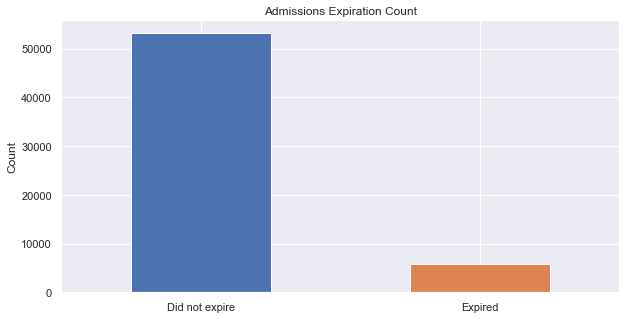

In [6]:
# target class count
admissions.hospital_expire_flag.apply(lambda x: 'Expired' if x else 'Did not expire').value_counts()\
.plot.bar(rot=0, figsize=(10,5),color=['C00','C01'])
plt.title('Admissions Expiration Count')
plt.ylabel('Count');

In [7]:
tot_adm = len(admissions)
pct_exp = round(100 * sum(admissions.hospital_expire_flag)/tot_adm,2)
md('''There were {} admissions in total. {}% of admitted patients expired. 
Some patients were admitted multiple times with admissions being a considerable time apart from each other.
Each admission could involve transfer to multiple intensive care units. This model is intended to predict a patients
likelihood of expiry at the first ICU.'''.format(tot_adm,pct_exp))

There were 58976 admissions in total. 9.93% of admitted patients expired. 
Some patients were admitted multiple times with admissions being a considerable time apart from each other.
Each admission could involve transfer to multiple intensive care units. This model is intended to predict a patients
likelihood of expiry at the first ICU.

As target classes are imbalanced, attempting balancing techniques may improve model performance.

### Base Features <a class="anchor" id="base_features"></a>

MIMIC III has a myriad of fields that could provide keen insights. Below are a few fields studied to get a better understanding of the data and to be used as features for modelling:<ul> <li>Age</li> <li>Height</li> <li>Weight</li> <li>Gender</li> <li>Heart Rate</li> <li>Temperature</li> <li>SpO2</li> <li>Blood Pressure</li> <li>Ethnicity</li> <li>Marital Status</li> <li>Diagnosis</li><li>Number of Admissions</li> <li>Admission Type</li></ul>

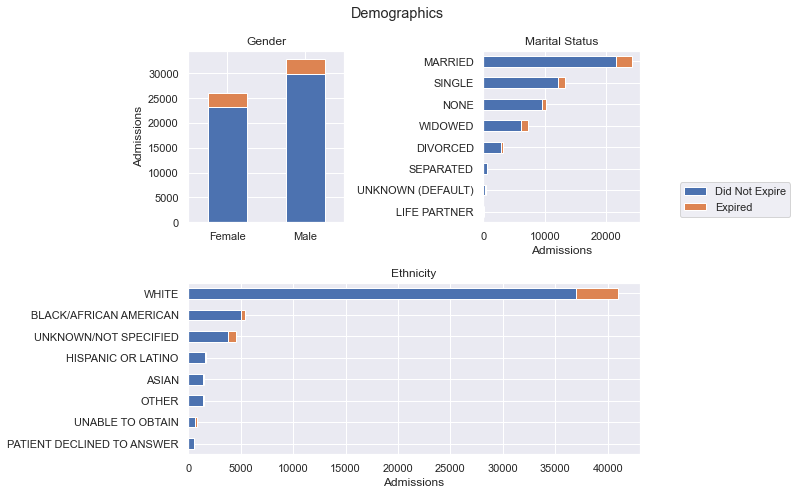

In [299]:
# plotting demographic: stats gender, ethnicity, martial status
plt.figure(figsize=(14,7))
plt.suptitle('Demographics', x=0.4)

# plotting gender count
gendplot = admissions.groupby(['gender','hospital_expire_flag']).agg(Admissions=('hadm_id','count'))
gendplot = gendplot.reset_index().pivot(columns='hospital_expire_flag',values='Admissions',index='gender')

ax1 = plt.subplot2grid((2,2),(0,0),colspan=1)
gendplot.plot.bar(stacked=True, ax=ax1, legend=False)
ax1.set_xticklabels(['Female','Male'], rotation=0)
plt.xlabel(None)
plt.ylabel('Admissions')
plt.title('Gender');

# plotting marital status
ax2 = plt.subplot2grid((2,2),(0,1),colspan=2)
mardf = admissions.replace({'marital_status':{None:'NONE'}}).groupby(['marital_status','hospital_expire_flag']).agg(Admissions=('hadm_id','count'))
mardf.rename_axis(index={'marital_status':'Marital Status'}, inplace=True)
mardf.reset_index(inplace=True)
mardf = mardf.pivot(columns='hospital_expire_flag', values='Admissions', index='Marital Status')
mardf.rename(columns={0:'Did Not Expire',1:'Expired'}, inplace=True)
mardf.sort_values(by='Did Not Expire').plot.barh(stacked=True, ax=ax2)
plt.legend(title=None, loc='lower right', bbox_to_anchor=(2,0) )
plt.title('Marital Status')
plt.ylabel(None)
plt.xlabel('Admissions')

# plotting ethnicity
ax3 = plt.subplot2grid((2,2),(1,0),colspan=2)
ethdf = admissions.groupby(['ethnicity','hospital_expire_flag']).agg(Admissions=('hadm_id','count')).reset_index()
ethdf = ethdf.pivot(columns='hospital_expire_flag', values='Admissions', index='ethnicity')
ethdf = ethdf.sort_values(by=0, ascending=False)[0:8].rename(columns={0:'Did Not Expire',1:'Expired'})
ethdf.sort_values(by='Did Not Expire').plot.barh(stacked=True, legend=False, ax=ax3)
plt.xlabel('Admissions')
plt.ylabel(None)
plt.title('Ethnicity')
plt.tight_layout()

The above visuals show admitted patients are primarily white and married (marital status of new borns are recorded as None). There is approximately an equal number of male and female admissions. Demographics do not show any significant bearing on patient survival.

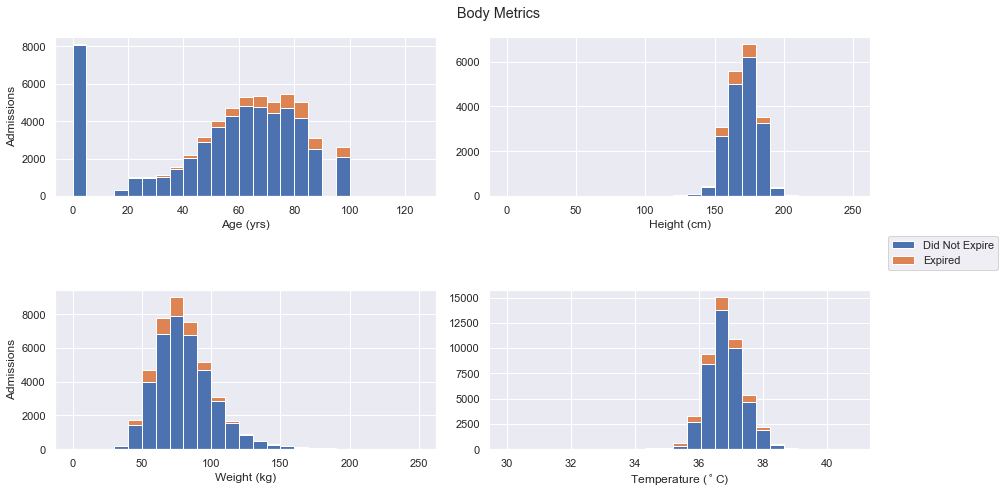

In [8]:
#plotting distributions for age, height, weight and temperature
plt.figure(figsize=(14,7))
plt.suptitle('Body Metrics')

plt.subplot(2,2,1)
plt.hist([admissions[admissions.hospital_expire_flag==0].age,admissions[admissions.hospital_expire_flag==1].age],\
          bins=25, range=(0,125), stacked=True);
plt.xlabel('Age (yrs)')
plt.ylabel('Admissions')

plt.subplot(2,2,2)
plt.hist([admissions[admissions.hospital_expire_flag==0].height,admissions[admissions.hospital_expire_flag==1].height],\
         bins=25,range=(0,250), stacked=True)
plt.xlabel('Height (cm)')
plt.legend(['Did Not Expire', 'Expired'], loc='lower right', bbox_to_anchor=(1.35,-0.5))

plt.subplot(2,2,3)
plt.hist([admissions[admissions.hospital_expire_flag==0].weight,admissions[admissions.hospital_expire_flag==1].weight],\
         range=(0,250), bins=25, stacked=True)
plt.ylabel('Admissions')
plt.xlabel('Weight (kg)')

plt.subplot(2,2,4)
plt.hist([admissions[admissions.hospital_expire_flag==0].tempc_mean,admissions[admissions.hospital_expire_flag==1].tempc_mean],\
         bins=25, stacked=True)
plt.xlabel('Temperature ($^\circ$C)')



plt.tight_layout()

**For privacy reasons, all patients above the age 89 are given an arbitrary age of 95.*

One insight gained from the above plots is that new born admissions (age is 0) have a near 100% survivial rate. Besides newborn admissions, all admitted patients are past 20yrs of age with death rates being higher for patients above 45yrs. 

The other metrics are distributed normally around the measures of an average human. These measures do not show any noticeable effects on expiration rates.

In [55]:
avg_measures = admissions[['height','weight','tempc_mean']].apply(np.mean).to_list()
md('''Average measures: 
{:.2f}cm height, {:.2f}kg weight and {:.2f}&deg;C temperature'''.format(avg_measures[0],avg_measures[1],avg_measures[2]))

Average measures: 
169.90cm height, 80.66kg weight and 36.82&deg;C temperature

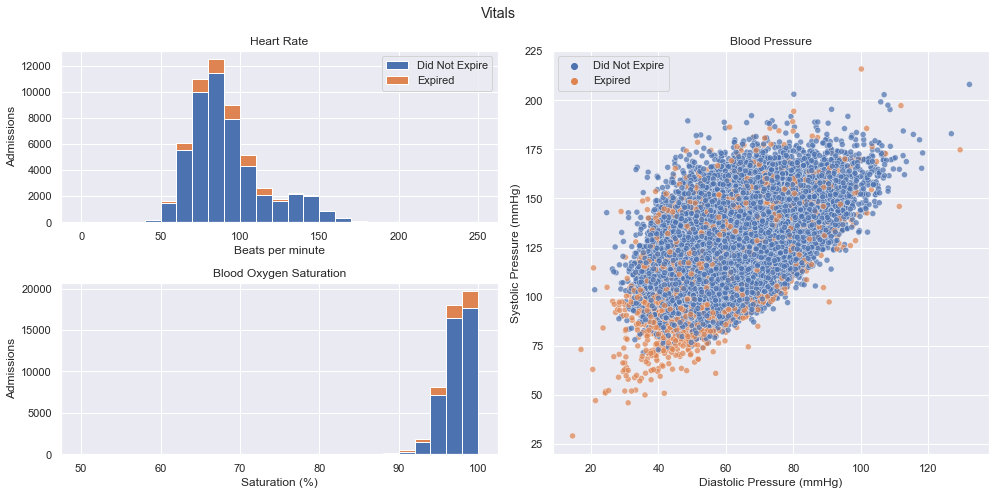

In [64]:
# plotting vitals
# heart rate, bp, sp02

adm_exp = admissions[admissions.hospital_expire_flag==1]
adm_surv = admissions[admissions.hospital_expire_flag==0]

plt.figure(figsize=(14,7))
plt.suptitle('Vitals')

# plotting heart rate
plt.subplot2grid((2,2), (0,0),colspan=1)
plt.hist([adm_surv.heartrate_mean,adm_exp.heartrate_mean], stacked=True, range=(0,250), bins=25)
plt.title('Heart Rate')
plt.xlabel('Beats per minute')
plt.ylabel('Admissions')
plt.legend(['Did Not Expire','Expired'],loc='upper right')

# plotting spO2
plt.subplot2grid((2,2), (1,0), colspan=1)
plt.hist([adm_surv.spo2_mean,adm_exp.spo2_mean], stacked=True, range=(50,100), bins=25)
plt.title('Blood Oxygen Saturation')
plt.xlabel('Saturation (%)')
plt.ylabel('Admissions')

# plotting
plt.subplot2grid((2,2),(0,1), colspan=1, rowspan=2)
sns.scatterplot(data=admissions.replace({'hospital_expire_flag':{0:'Did Not Expire',1:'Expired'}}),\
                x='diasbp_mean', y='sysbp_mean', hue='hospital_expire_flag', alpha=0.7)
plt.legend(title=None)
plt.title('Blood Pressure')
plt.xlabel('Diastolic Pressure (mmHg)')
plt.ylabel('Systolic Pressure (mmHg)')
plt.tight_layout()

Heart Rate and Blood Oxygen Saturation data did not exhibit strong trends to indicate patient death. The Blood pressure scatter plot suggests patients that expire recorded low diastolic and systolic pressure (plotted values are mean pressures). Normal systolic and diastolic pressures are considred to be 120 mmHg and 80 mmHg respectively. There is a high density of expired patients below the 100 mmHg systolic and 60 mmHg diastolic levels.

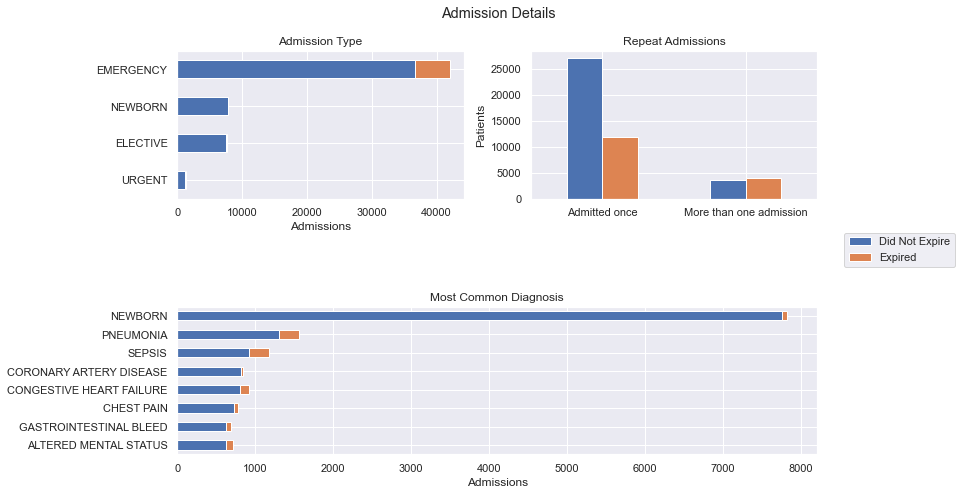

In [12]:
# plotting admissions details: admission type, diagnosis, previous admissions
plt.figure(figsize=(14,7))
plt.suptitle('Admission Details',x=0.5)

ax1 = plt.subplot2grid((2,2), (0,0), colspan=1)
admissions.groupby(['admission_type','hospital_expire_flag']).agg(Admissions=('hadm_id','count')).reset_index() \
.pivot(values='Admissions',columns='hospital_expire_flag',index='admission_type').sort_values(by=0)\
.plot.barh(stacked=True, legend=False, ax=ax1)
plt.title('Admission Type')
plt.ylabel(None)
plt.xlabel('Admissions')

ax2 = plt.subplot2grid((2,2), (0,1), colspan=1)
# calculating number of times a patient is admitted
staycount = admissions.groupby('subject_id').agg(staycount=('row_id','count'))
patients2 = patients.join(staycount, how='left', on='subject_id')

# stay count vs expiration
stay_exp = patients2.groupby(['staycount','expire_flag']).agg(number_of_patients=('row_id','count'))
# grouping to admitted and readmitted
stay_exp_grpd = stay_exp.reset_index()
stay_exp_grpd['readmitted'] = stay_exp_grpd['staycount']>1
stay_exp_grpd['readmitted'] = stay_exp_grpd['readmitted'].apply(lambda x: 'More than one admission' if x else 'Admitted once')
stay_exp_grpd = stay_exp_grpd.drop(columns=['staycount']).groupby(['readmitted','expire_flag']).sum()

# plotting no readmission vs readmission
stay_exp_grpd.reset_index().pivot(index='readmitted', columns='expire_flag', values='number_of_patients')\
    .plot.bar(title='Repeat Admissions', 
              xlabel='',ylabel='Patients', rot=0, ax=ax2)
plt.legend(['Did Not Expire','Expired'], loc='lower right', bbox_to_anchor=(1.5,-0.5))



ax3 = plt.subplot2grid((2,2), (1,0), colspan=2)
admissions.groupby(['diagnosis','hospital_expire_flag']).agg(Admissions=('hadm_id','count')).reset_index() \
.pivot(values='Admissions', columns='hospital_expire_flag', index='diagnosis').sort_values(by=0, ascending=False)[0:8]\
.sort_values(by=0).plot.barh(stacked=True, ax=ax3, legend=False)
plt.ylabel(None)
plt.xlabel('Admissions')
plt.title('Most Common Diagnosis')

plt.tight_layout()

Almost all expired patients were admitted with an *emergency* admission type. Almost all patients with an *elective* admission type survived, suggesting precautionary measures could increase chances of survival. *Pneumonia* and *Sepsis* were the most common diagnosis which resulted in high patient death.

Patients with repeat ICU admissions exhibited a significantly decreased chance of survival. The effects of readmission can be interpreted with better confidence by pooling all readmissions into one group (admitted 2 or more times). A third of patients admitted once expired, whereas more than half of readmitted patients expired.

In [4]:
# selecting all columns to be used in model
feature_df = admissions[['admission_type'
                         ,'marital_status'
                         ,'ethnicity'
                         ,'diagnosis'
                         ,'prev_stays'
                         ,'gender'
                         ,'age'
                         ,'height'
                         ,'weight'
                         ,'heartrate_mean'
                         ,'sysbp_mean'
                         ,'diasbp_mean'
                         ,'tempc_mean'
                         ,'spo2_mean'
                         ,'sapsii'
                         ,'sofa'
                         ,'hospital_expire_flag']]


### Engineered Features<a class="anchor" id="engineered_features"></a>

**The Simple Acute Physiology Score II (SAPSII)** <br>
SAPSII is a measure of disease severity for ICU patients. It was researched and devised by Dr. Jean-Roger Le Gall, head of the ICU at Saint-Louis University Hospital in Paris, France, et al. His findings were published in the Journal of the American Medical Association. 

The SAPSII score is calcualted 24 hours after admission based on various patient details including age, heart rate, chronic disease, urine output, blood tests, etc. SAPSII is intended to estimate mortality risk for a group of patients, and not intended for individual patients.

**Sequential Organ Failure Assessment (SOFA)** <br>
SOFA is a score calculated for ICU patients to determine the extent of organ failure. The SOFA score is calculated every 24 hours until discharge. SOFA calculation is comprised of 6 other scores corresponding to respiratory, cardiovascular, hepatic, coagulation, renal and neurological systems of the human body. SOFA was created by Dr.Jean-Louis Vincent, head of the Department of Intensive Care at Erasme University Hospital, et. al. His findings were published in Intensive Care Medicine.

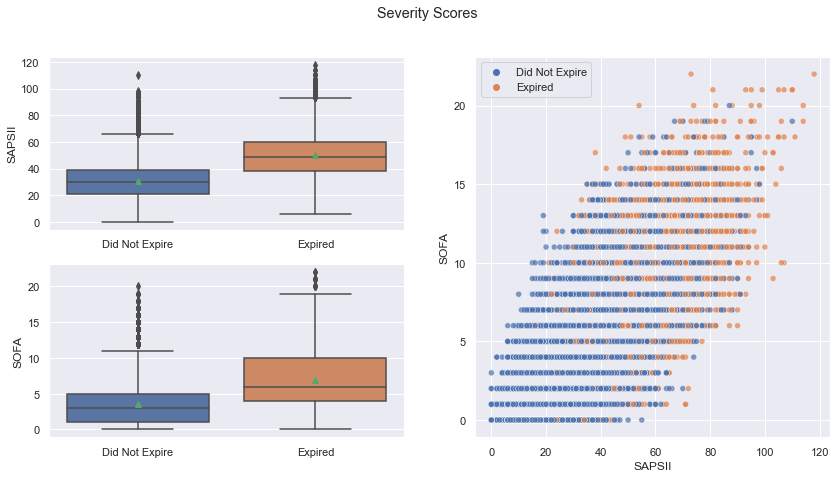

In [26]:
plt.figure(figsize=(14,7))
plt.suptitle('Severity Scores')

ax1 = plt.subplot2grid((2,2), (0,0), colspan=1)
sns.boxplot(data=admissions, x='hospital_expire_flag', y='sapsii', showmeans=True)
plt.ylabel('SAPSII')
plt.xlabel(None)
ax1.set_xticklabels(['Did Not Expire','Expired'])

ax2 = plt.subplot2grid((2,2), (1,0), colspan=1)
sns.boxplot(data=admissions, x='hospital_expire_flag', y='sofa', showmeans=True)
plt.ylabel('SOFA')
plt.xlabel(None)
ax2.set_xticklabels(['Did Not Expire','Expired'])

plt.subplot2grid((2,2), (0,1), colspan=1, rowspan=2)
scatplot = sns.scatterplot(data=admissions.replace({'hospital_expire_flag':{0:'Did Not Expire', 1:'Expired'}}), 
                           x='sapsii', y='sofa', hue='hospital_expire_flag', alpha=0.7)
plt.legend(title=None)
plt.xlabel('SAPSII')
plt.ylabel('SOFA');

Although there is some overlap, patients who expired generally had higher SAPSII and SOFA scores.

### Multicollinearity

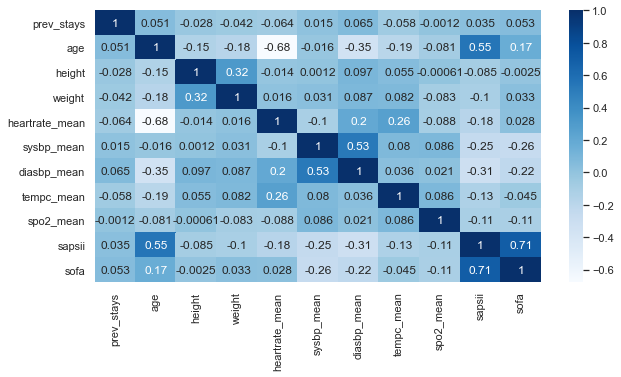

In [56]:
plt.figure(figsize=(10,5))
corrmat = feature_df.drop(columns=['hospital_expire_flag']).corr()
sns.heatmap(corrmat, cmap='Blues', annot=True);

The above figure visualizes the correlation between features. Removing highly correlated variables is good practice as it will help in interpretting feature affects on model predictions. Removing correlated features can be carried out during feature selection.

SAPSII and SOFA are highly correlated and one maybe removed during feature selection.

Intution suggests systolic and diastolic blood pressures would be highly correlated. Although the correlation coefficient between these features shows some correlation, it is not significantly high.

### Missing Data

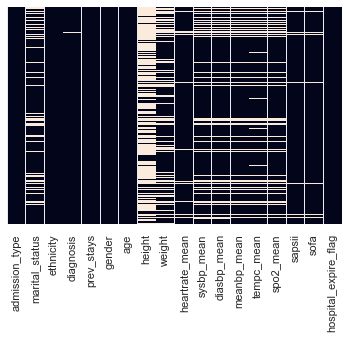

In [54]:
sns.heatmap(feature_df.isnull(), cbar=False, yticklabels=False);

Height is missing in almost all rows. Missing values will be imputed with the mean or mode during data prep. It  is likely height will not provide models with much information and will have low feature importance.

## Model Development<a class="anchor" id="model_development"></a>

### Data Prep <a class="anchor" id="data_prep"></a>

In [5]:
# split test and train
X_train, X_test, y_train, y_test = train_test_split(feature_df.iloc[:,:-1], 
                                                    feature_df.iloc[:,-1], 
                                                    random_state=42, test_size=0.25)

In [6]:
# Transformer classes to be used in data processing pipeline

class FeatureSelector(BaseEstimator, TransformerMixin):
    ''' Class which returns selected columns from dataframe'''
    
    def __init__(self, feature_names):
        ''' Class Constructor '''
        self.feature_names = feature_names 
     
    def fit(self, X, y = None):
        ''' Return self, fit function has no affect and simply returns dataframe as is ''' 
        return self 
    
    def transform(self, X, y = None):
        ''' Returns Dataframe with specified columns '''
        return X[ self.feature_names ]
    
    def get_feature_names(self):
        return X.columns.tolist()
    
    
class CategoricalCleaner(BaseEstimator, TransformerMixin):
    ''' Cleans categorical columns in data processing pipeline. '''
    
    def fit(self, X, y = None):
        ''' Return self, fit function has no affect and simply returns dataframe as is '''
        self.X = X
        return self
    
    def transform(self, X, y = None):
        ''' Imputes Marital Status and Ethnicity and Cleans Admission Type and Ethnicity columns. '''
        
        # Replace na values in marital_status and ethnicity columns
        X.fillna({'marital_status':'NONE', 'ethnicity':'UNABLE TO OBTAIN'}, inplace=True)
        
        # Cleaning ethnicity column
        X.ethnicity = X.ethnicity.apply(lambda x:x.split(' -')[0]).replace('HISPANIC OR LATINO', 'HISPANIC/LATINO')
        
        # Cleaning diagnosis column
        prog = prog = re.compile(r'^[a-zA-Z ]*')
        X.diagnosis = X.diagnosis.apply(lambda x: prog.search(x).group(0) if x!=None else x)
        common_diagnosis = ['NEWBORN', 'CORONARY ARTERY DISEASE', 'PNEUMONIA', 'CHEST PAIN',
                            'SEPSIS', 'CONGESTIVE HEART FAILURE', 'AORTIC STENOSIS',
                            'GASTROINTESTINAL BLEED', 'ALTERED MENTAL STATUS']
        X.diagnosis = X.diagnosis.apply(lambda x: x if x in common_diagnosis else 'OTHER')
        
        return X
    
    def get_feature_names(self):
        return self.X.columns.tolist()

In [7]:
# getting categorical and numercal columns
cat_cols = X_train.select_dtypes('object').columns
num_cols = X_train.select_dtypes(exclude='object').columns



# impute all other categorical columns and make dummy columns
cat_pipe = Pipeline([('select', FeatureSelector(cat_cols)),
                     ('clean', CategoricalCleaner()),
                     ('impute', SimpleImputer(strategy='most_frequent')),
                     ('onehot', OneHotEncoder(sparse=False))])


# impute all numerical columns and scale them
num_pipe = Pipeline([('select',FeatureSelector(num_cols)),
                     ('impute', SimpleImputer(strategy='median')),
                     ('scale',StandardScaler())])

# combining categorical and numerical pipelines
preprocessor = FeatureUnion([('numerical_pipeline', num_pipe)
                             ,('categorical_pipeline', cat_pipe)])

preprocessor.fit(X_train);

new_cat_cols = preprocessor.transformer_list[1][1][3].get_feature_names(cat_cols)
pipeline_cols = np.append(num_cols, new_cat_cols)


# transforming training and testing data
tX_train = pd.DataFrame(preprocessor.transform(X_train), 
                        columns=pipeline_cols, 
                        index=X_train.index)

tX_test = pd.DataFrame(preprocessor.transform(X_test), 
                       columns=pipeline_cols, 
                       index=X_test.index)

Numerical features were imputed using the median for each respective feature. Missing categorical entries were filled with a value to indicate missing value. For the diagnosis feature, diagnosis other than top 9 common diagnosis were changed to 'OTHER'.

After splitting categorical features to respective dummy features, there a total of **54 feature columns**.

In [8]:
def predscore(typred, typroba, tyvali):
    """ Function to print out performance metrics for model predictions
    
    Parameters:
        typred (list): y predictions from model.
        typroba (list): probabilities for class 1 predicted by model.
        tyvali (list): y validation set with true y values to compare against predictions.
        
    Returns:
        prints various scoring metrics. """
    
    print('Classfication Report')
    print(classification_report(tyvali, typred))
    
    print('Confusion Matrix')
    display(pd.DataFrame(confusion_matrix(tyvali, typred), 
                         columns = ['Did Not Expire', 'Expired'],
                         index=['Did Not Expire', 'Expired']))

### Logistic Regression <a class="anchor" id="logistic_regression"></a>

Logistic regression is a good start for any classification task. Logistic regression models are computationally lightweight and highly interprettable.

Recursive Feature Elimination (RFE) was carried out fitting multiple Logistic Regression models with L1 regularization (Lasso).

In [9]:
# l1(lasso regularization) chosen to reduce coefficients to 0, 
#5 Cs (alphas) tested with 3cv fits for a total 15fits
clf = LogisticRegressionCV(Cs=5, solver='liblinear', penalty='l1', cv=3, fit_intercept=True)

# (54 features - 1 min feature)/ 5 per step results in 12 rounded up steps with 3cv totalling to 36 RFE fits
min_feat=1
rfestep=5
rfeclf = RFECV(clf, step=rfestep, min_features_to_select=min_feat, scoring='roc_auc', cv=3)

#36 rfe fits and 15 lrcv fits per rfe it totals to 540fits
results = rfeclf.fit(tX_train, y_train)

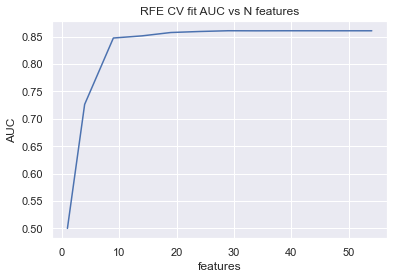

In [16]:
n_feats = list(range(len(tX_train.columns), min_feat, -rfestep))
if len(n_feats)<len(results.grid_scores_): 
    n_feats.append(min_feat)

n_feats = np.flip(n_feats)

pd.DataFrame(np.transpose([n_feats, results.grid_scores_]), columns=['features','AUC'])\
.plot(x='features',y='AUC', legend=False, title='RFE CV fit AUC vs N features')\
.set_ylabel('AUC');

The RFE setup steps through the 54 features, removing 5 at each step. There is an elbow point at 9 features, with a steep drop in AUC, suggesting the optimal number of features is about 9 features. Including anymore features, results in diminishing returns.

In [17]:
# fitting RFE again to get 9 best features
best_nfeats = 9
rfefinal = RFE(clf, n_features_to_select=best_nfeats, step=rfestep)
finresults = rfefinal.fit(tX_train,y_train)


In [24]:
# Statsmodels logit provides a better summary than sklearn's Logistic regression
# fitting sm logit with best RFE features
smclf = sm.Logit(y_train, sm.add_constant(tX_train.iloc[:,finresults.support_]))
smresult = smclf.fit(maxiter=1000, disp=0);

The best 9 features from RFE logistic regression were taken to fit a simple logistic regression model. Summary of this first fit showed coefficients for black/haitian and middle eastern ethnicity status have p-values above 0.05 and therefore have a low confidence. These features were removed and logistic regression was fit again to get a final logistic regression model with the below summary.

In [112]:
from IPython.core.display import HTML

In [106]:
%%html
<script>
function toggle_next(event) {
    $(event.target).closest('div.jp-Cell').next().find('div.jp-OutputArea').toggle();
    $(event.target).closest('div.code_cell').next().find('div.output').toggle();
}
</script>
<a onclick="toggle_next(event)" id="log1st"> Click here to see summary of first fit. </a>

<script>
$(function() {
    $('#log1st').click();
});
</script>

In [119]:
display(HTML('''<h4>First logistic regression fit summary</h4>'''))
smresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     hospital_expire_flag   No. Observations:                44232
Model:                            Logit   Df Residuals:                    44222
Method:                             MLE   Df Model:                            9
Date:                  Fri, 16 Apr 2021   Pseudo R-squ.:                  0.2499
Time:                          12:28:01   Log-Likelihood:                -10765.
converged:                         True   LL-Null:                       -14352.
Covariance Type:              nonrobust   LLR p-value:                     0.000
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -2.5396      0.025   -102.999      0.000      -2.588      -2.491
sapsii                                                  1.2158      0.019     63.541      0.000       1.178       1.253
admission_type_ELECTIVE                                -1.1010      0.091    -12.064      0.000      -1.280      -0.922
admission_type_NEWBORN                                 -1.7196      0.156    -11.015      0.000      -2.026      -1.414
ethnicity_BLACK/HAITIAN                                -0.9176      0.538     -1.704      0.088      -1.973       0.138
ethnicity_MIDDLE EASTERN                               -1.6708      1.064     -1.571      0.116      -3.755       0.414
ethnicity_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER     1.7077      0.755      2.261      0.024       0.227       3.188
diagnosis_AORTIC STENOSIS                              -1.8091      0.351     -5.160      0.000      -2.496      -1.122
diagnosis_CHEST PAIN                                   -0.8693      0.139     -6.252      0.000      -1.142      -0.597
diagnosis_CORONARY ARTERY DISEASE                      -1.5861      0.148    -10.683      0.000      -1.877      -1.295
=======================================================================================================================
"""

In [109]:
# cols to fit after removing features of low confidence
smclf2cols = list(tX_train.columns[finresults.support_])
smclf2cols.remove('ethnicity_BLACK/HAITIAN')
smclf2cols.remove('ethnicity_MIDDLE EASTERN')

# fitting sm again based on results from first fit
smclf2 = sm.Logit(y_train, sm.add_constant(tX_train[smclf2cols]))
smresult2 = smclf2.fit(maxiter=1000, disp=0);

In [120]:
display(HTML('''<h4>Final logistic regression fit summary</h4>'''))
smresult2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     hospital_expire_flag   No. Observations:                44232
Model:                            Logit   Df Residuals:                    44224
Method:                             MLE   Df Model:                            7
Date:                  Fri, 16 Apr 2021   Pseudo R-squ.:                  0.2497
Time:                          12:28:22   Log-Likelihood:                -10769.
converged:                         True   LL-Null:                       -14352.
Covariance Type:              nonrobust   LLR p-value:                     0.000
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                  -2.5417      0.025   -103.120      0.000      -2.590      -2.493
sapsii                                                  1.2154      0.019     63.540      0.000       1.178       1.253
admission_type_ELECTIVE                                -1.0997      0.091    -12.051      0.000      -1.279      -0.921
admission_type_NEWBORN                                 -1.7183      0.156    -11.006      0.000      -2.024      -1.412
ethnicity_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER     1.7095      0.755      2.263      0.024       0.229       3.190
diagnosis_AORTIC STENOSIS                              -1.8074      0.351     -5.155      0.000      -2.494      -1.120
diagnosis_CHEST PAIN                                   -0.8682      0.139     -6.245      0.000      -1.141      -0.596
diagnosis_CORONARY ARTERY DISEASE                      -1.5844      0.148    -10.672      0.000      -1.875      -1.293
=======================================================================================================================
"""

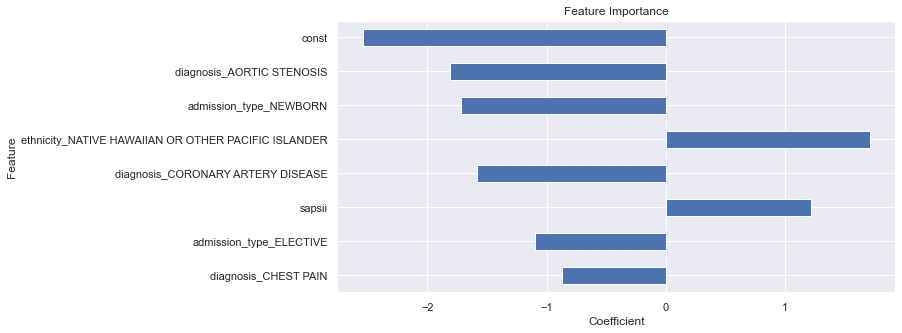

In [128]:
feat_impdf = pd.DataFrame(smresult2.params).rename(columns={0:'coef'})
feat_impdf['abs'] = abs(feat_impdf['coef'])
feat_impdf.sort_values(by='abs', ascending=False).head(10)\
.sort_values(by='abs', ascending=True)['coef'].plot.barh(legend=False,figsize=(10,5), 
                                                         title='Feature Importance')\
.set_xlabel('Coefficient')
plt.ylabel('Feature');

In [146]:

temptestdf = sm.add_constant(tX_test[smclf2cols])
testy_proba = pd.DataFrame(smresult2.predict(temptestdf))
lr_test_auc = roc_auc_score(y_true = y_test, y_score = testy_proba)

display(HTML('''Logistic Regression test AUC score: <b>{0:.2f}</b>'''.format(lr_test_auc)))

### Gradient Boosted Trees <a class="anchor" id="grad_boost_trees"></a>

Gradient boosted trees work well with imbalanced classes, as is the case for this dataset.

### Support Vector Machine (SVM) <a class="anchor" id="svm"></a>

Support Vector Machines may find patterns which may be imperceptible without using their kernel trick approach.

## Best Model Analysis<a class="anchor" id="model_analysis"></a>

## Conclusions<a class="anchor" id="conclusions"></a>

## Acknowledgements <a class="anchor" id="acknowledgements"></a>
The MIMIC III database was made available through the efforts of MIT Laboratory for Computational Physiology and collaborating research groups and supported by National Institute of Biomedical Imaging and Bioengineering (NIBIB) of the National Institutes of Health (NIH). <br><br>
Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).


## References <a class="anchor" id="references"></a>
Simplified Acute Physiology Score (SAPS) II<br>
https://www.mdcalc.com/simplified-acute-physiology-score-saps-ii#pearls-pitfalls

Sequential Organ Failure (SOFA) Score<br>
https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score#pearls-pitfalls

In [147]:
# cli code to convert notebook to html
!jupyter nbconvert --to html icu_mortality_prediction.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --TagRemovePreprocessor.remove_input_tags='{"hide_input"}'


C:\ProgramData\Anaconda3\lib\site-packages\traitlets\traitlets.py:2199: FutureWarning: Supporting extra quotes around Unicode is deprecated in traitlets 5.0. Use 'remove_cell' instead of "'remove_cell'" – or use CUnicode.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\traitlets\traitlets.py:2199: FutureWarning: Supporting extra quotes around Unicode is deprecated in traitlets 5.0. Use 'hide_input' instead of "'hide_input'" – or use CUnicode.
  FutureWarning)
[NbConvertApp] Converting notebook icu_mortality_prediction.ipynb to html
[NbConvertApp] Writing 1430399 bytes to icu_mortality_prediction.html
